In [1]:
import numpy as np
from numpy.random import multinomial
import matplotlib.pyplot as plt
import warnings
from __future__ import division
import seaborn as sns
from scipy.stats import bernoulli, beta, binom
%matplotlib inline

In [2]:
def policy(params, method):
    """
    
    1. policy to determine which machine to select
    2. returns 0 or 1
    3. inputs (a1,a2,b1,b2) should be integers
    4. method should be either exploitation, exploration or proportion
    
    """
    
    if method == 'exploit':
        return np.argmax([float(a)/(a+b) for (a,b) in params])
    elif method == 'explore':
        k = len(params)
        return np.argmax(multinomial(1,np.repeat(float(1)/k,k)))
    elif method == 'thompson':
        return np.argmax([beta.rvs(a,b) for (a,b) in params])
    

In [3]:
def thompson_sampler(method, N, K, true_theta):
    """
    Implement Thompson Sampler
    
    Parameters
    -----
    
    method: exploit, explore, thompson
    N: number of iterations of the sampler
    K: number of machine
    
    Returns
    -----
    
    machine: array that holds the winning machine at each iteration
    sum(reward): the total reward
    theta: vector of parameters for each machine
    regret: vector of "rewards" if the machine with the maximum theta was always chosen
    
    """
    
    # remove numpy warnings for indexing with non-integers
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        machine = np.empty(N)
        reward = np.empty(N)
        
        regret = np.zeros(N)
        theta = np.ones(2*K).reshape(K,2) # prior is beta(1,1) for each machine

        for t in range(N):

            machine[t] = policy(theta, method)

            # sample reward using true probability
            reward_theta = true_theta[machine[t]]

            # if best machine selected, then regret should be 0
            regret[t] = bernoulli.rvs(max(true_theta))
           
            if reward_theta == max(true_theta):
                reward[t] = regret[t]
            else:
                reward[t] = bernoulli.rvs(reward_theta)

            if reward[t] == 1:
                theta[machine[t]][0] += 1 
            else:
                theta[machine[t]][1] += 1
            
        return machine, reward, theta, regret

In [4]:
def epsilon_greedy(epsilon, N, K, true_theta):
    
    #set up parameters
    true_best_machine = np.argmax(true_theta)
    theta = np.ones(2*K).reshape(K,2) # prior is beta(1,1) for each machine
    reward = np.zeros(N)
    regret = np.zeros(N)
    machine = np.empty(N)
    
    #Post first play
    for t in range(N):
        
        #Generate an epsilon decision
        epsilon_decision = bernoulli.rvs(epsilon)
        
        #If epsilon decision is 1, explore
        if(epsilon_decision==1):
            #Choose a machine randomly
            machine[t] = policy(theta, 'explore')  
        
        #If epsilon is 0, exploit best machine    
        else:
            #Choose machine with highest expected value
            machine[t] = policy(theta, 'exploit')
  
        # if best machine selected, then regret should be 0
        regret[t] = bernoulli.rvs(max(true_theta))
        
        reward_theta = true_theta[int(machine[t])]
        
        if reward_theta == max(true_theta):
            reward[t] = regret[t]
        else:
            reward[t] = bernoulli.rvs(reward_theta)
         
        #update theta
        if (reward[t] == 1):
            theta[int(machine[t])][0] += 1
        else:
            theta[int(machine[t])][1] += 1 
            
    
    return machine, reward, theta, regret


In [5]:
# xvals = np.linspace(0,1,100)
# f = lambda x: beta.pdf(x, param[0], param[1])

# np.random.seed(121)
# N = [10,50,100] # number of iterations
# K = 5 # number of machines

# xvals = np.linspace(0,1,100)
# colors = ["g","b","y","m","c"]
# true_theta = np.array([0.05,0.1,0.3,0.2,0.5])

# for num in N:
    
#     machines, R, theta, max_regret = thompson_sampler('thompson', num, K, true_theta)
    
#     for e, param in enumerate(theta):
        
#         f = lambda x: beta.pdf(x, param[0], param[1])
        
#         plt.title("Posterior distributions after {} runs".format(num), size=14)
#         plt.plot(xvals, f(xvals), color = colors[e], label = e)
#         plt.vlines(true_theta[e],ymin=0,ymax=max(f(xvals)),linewidth=1,linestyle='--')
#         plt.fill_between(xvals,f(xvals), alpha=0.6, color = colors[e])
#         plt.legend(loc='best')
        
        
#     plt.show()

In [42]:
N = 1000
K = 15
T = 30
#np.random.seed(122)

true_theta = np.array([0.05,0.1,0.3,0.2,0.5,0.05,0.1,0.3,0.2,0.9,0.2,0.5,0.05,0.1,0.3])


In [43]:
explore_actual = np.zeros(T*N).reshape(T,N)
explore_max = np.zeros(T*N).reshape(T,N)

exploit_actual = np.zeros(T*N).reshape(T,N)
exploit_max = np.zeros(T*N).reshape(T,N)

thompson_actual = np.zeros(T*N).reshape(T,N)
thompson_max = np.zeros(T*N).reshape(T,N)

egreedy_actual = np.zeros(T*N).reshape(T,N)
egreedy_max = np.zeros(T*N).reshape(T,N)

for i in range(T):
    explore = thompson_sampler('explore', N, K, true_theta)
    exploit = thompson_sampler('exploit', N, K, true_theta)
    thompson = thompson_sampler('thompson', N, K, true_theta)
    egreedy = epsilon_greedy(0.1, N, K, true_theta)
    
    explore_actual[i] = explore[1]
    explore_max[i] = explore[3]
    
    exploit_actual[i] = exploit[1]
    exploit_max[i] = exploit[3]
    
    thompson_actual[i] = thompson[1]
    thompson_max[i] = thompson[3]
    
    egreedy_actual[i] = egreedy[1]
    egreedy_max[i] = egreedy[3]


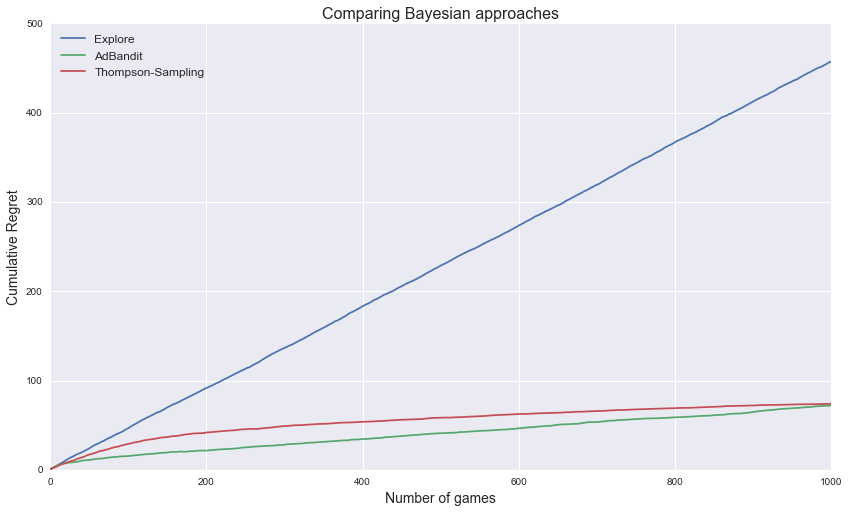

In [41]:
plt.figure(figsize=(14,8))
plt.title("Comparing Bayesian approaches",size=16)
plt.ylabel("Cumulative Regret",size=14)
plt.xlabel("Number of games",size=14)
plt.plot(np.mean(np.cumsum(explore_max-explore_actual,axis=1),axis=0))
plt.plot(np.mean(np.cumsum(exploit_max-exploit_actual,axis=1),axis=0))
plt.plot(np.mean(np.cumsum(thompson_max-thompson_actual,axis=1),axis=0))
plt.legend(['Explore','AdBandit','Thompson-Sampling'],loc='best',fontsize=12)
plt.show()

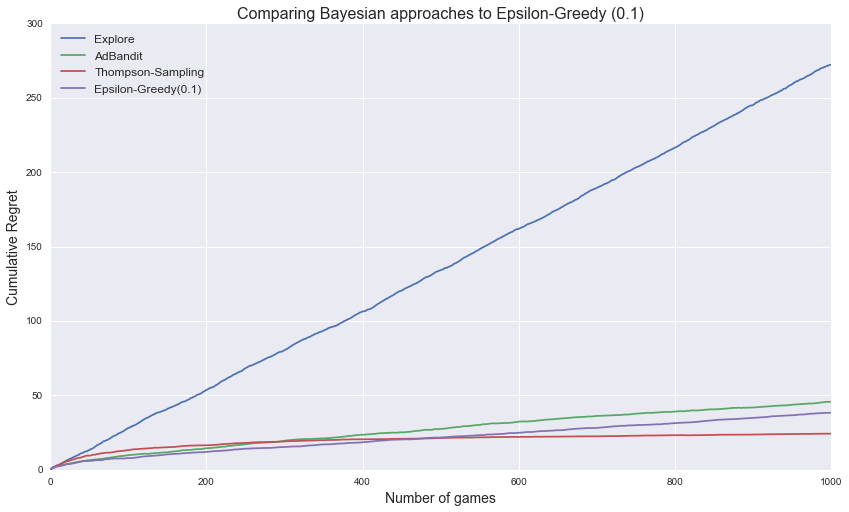

In [27]:
plt.figure(figsize=(14,8))
plt.title("Comparing Bayesian approaches to Epsilon-Greedy (0.1)",size=16)
plt.ylabel("Cumulative Regret",size=14)
plt.xlabel("Number of games",size=14)
plt.plot(np.mean(np.cumsum(explore_max-explore_actual,axis=1),axis=0))
plt.plot(np.mean(np.cumsum(exploit_max-exploit_actual,axis=1),axis=0))
plt.plot(np.mean(np.cumsum(thompson_max-thompson_actual,axis=1),axis=0))
plt.plot(np.mean(np.cumsum(egreedy_max-egreedy_actual,axis=1),axis=0))
plt.legend(['Explore','AdBandit','Thompson-Sampling', 'Epsilon-Greedy(0.1)'],loc='best',fontsize=12)
plt.show()

In [28]:
"""
UCB1 Algorithm
"""

def UCB1():
    machine_reward = true_theta

    machine_list = np.array(range(K))
    r = np.zeros(K)
    n = np.ones(K)
    mu = r/n

    machine_played = np.zeros(K*(N-K)).reshape((N-K),K)
    machine_wins = np.zeros(K*(N-K)).reshape((N-K),K)
    regret = np.zeros(N-K)

    for t in range(K,N):

        machine = np.argmax(mu + np.sqrt(2*np.log(t)/n))  

        regret[t-K] += bernoulli.rvs(max(machine_reward))

        if machine_reward[machine] == max(machine_reward):
            r[machine] += regret[t-K]
        else:
            r[machine] += bernoulli.rvs(machine_reward[machine])

        n[machine] += 1

        machine_played[t-K] = n
        machine_wins[t-K] = r

        mu[machine] = r[machine]/n[machine]
        
    
    return np.cumsum(regret), np.sum(machine_wins,axis=1), machine_wins, machine_played

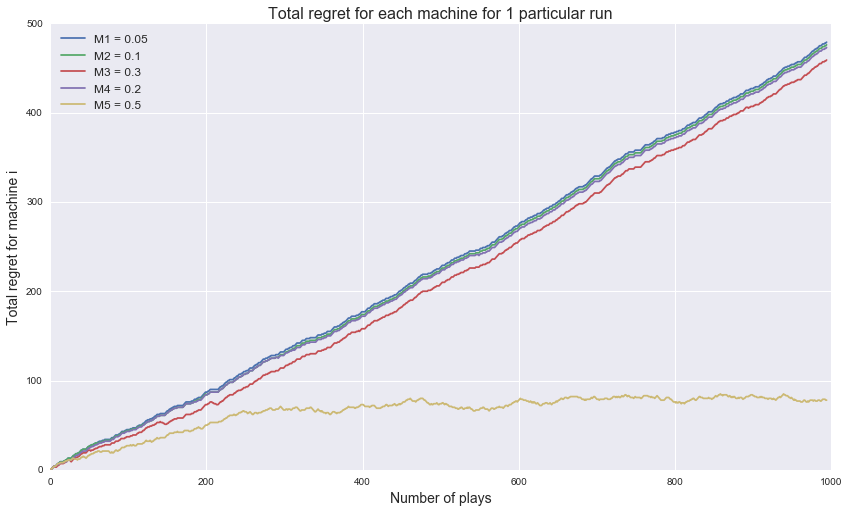

In [29]:
"""
Plot regret for each machine compared against each other
"""

ucb_max_1 = UCB1()[0]
ucb_actual_1 = UCB1()[2]

plot_regret = (ucb_max_1 - ucb_actual_1.T).T
plt.figure(figsize=(14,8))
plt.title("Total regret for each machine for 1 particular run",size=16)
plt.plot(plot_regret)
plt.legend(['M1 = {}'.format(true_theta[0]),
            'M2 = {}'.format(true_theta[1]),
            'M3 = {}'.format(true_theta[2]),
            'M4 = {}'.format(true_theta[3]),
            'M5 = {}'.format(true_theta[4])],
          loc='best',fontsize=12)
plt.ylabel("Total regret for machine i",size=14)
plt.xlabel("Number of plays",size=14)
            
pass

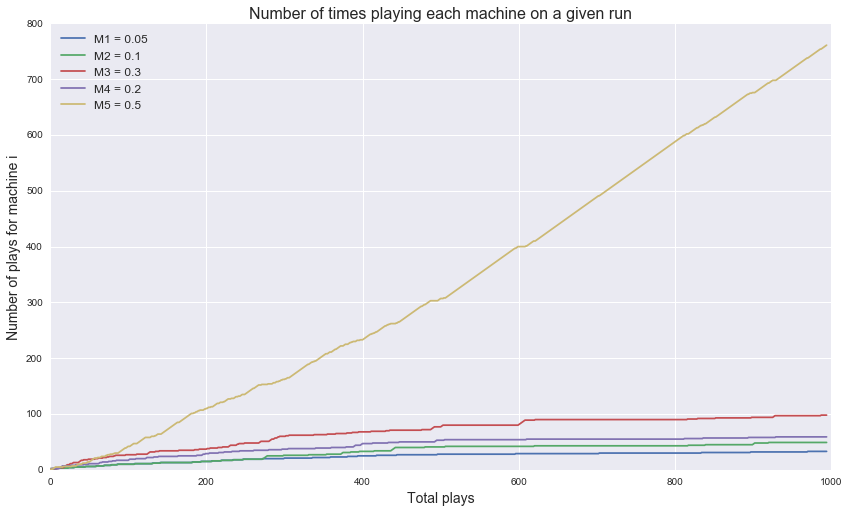

In [30]:
"""
Plot number of times each machine is played for a given run
"""


# ucb_max_1 = 
# ucb_actual_1 = UCB1()[2]

# plot_regret = (ucb_max_1 - ucb_actual_1.T).T

plt.figure(figsize=(14,8))
plt.title("Number of times playing each machine on a given run",size=16)
plt.plot(UCB1()[3])
plt.legend(['M1 = {}'.format(true_theta[0]),
            'M2 = {}'.format(true_theta[1]),
            'M3 = {}'.format(true_theta[2]),
            'M4 = {}'.format(true_theta[3]),
            'M5 = {}'.format(true_theta[4])],
          loc='best',fontsize=12)
plt.ylabel("Number of plays for machine i",size=14)
plt.xlabel("Total plays",size=14)
            
pass

In [31]:
ucb_max = np.zeros(T*(N-K)).reshape(T,(N-K))
ucb_actual = np.zeros(T*(N-K)).reshape(T,(N-K))
for i in range(T):
    ucb = UCB1()
    ucb_max[i] = ucb[0]
    ucb_actual[i] = ucb[1]

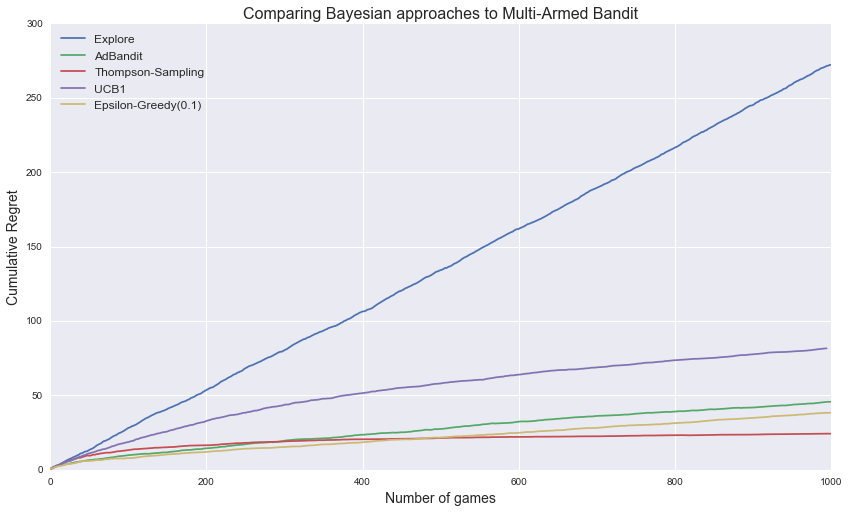

In [32]:
"""
Plot comparing cumulative regret of the mean of T runs of UCB1 compared to other approaches
"""

plt.figure(figsize=(14,8))
plt.title("Comparing Bayesian approaches to Multi-Armed Bandit",size=16)
plt.ylabel("Cumulative Regret",size=14)
plt.xlabel("Number of games",size=14)
plt.plot(np.mean(np.cumsum(explore_max-explore_actual,axis=1),axis=0))
plt.plot(np.mean(np.cumsum(exploit_max-exploit_actual,axis=1),axis=0))
plt.plot(np.mean(np.cumsum(thompson_max-thompson_actual,axis=1),axis=0))
plt.plot(np.mean(ucb_max - ucb_actual,axis=0))
plt.plot(np.mean(np.cumsum(egreedy_max-egreedy_actual,axis=1),axis=0))
plt.legend(['Explore','AdBandit','Thompson-Sampling','UCB1', 'Epsilon-Greedy(0.1)'],loc='best',fontsize=12)
plt.show()